In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from growth.sweep.sweep import Sweep
from clones.validation.sweep import SweepBenchmark
%matplotlib inline

In [2]:
ls ../synthetic/landing/

Sweep_181201_191409/ Sweep_181201_191516/ Sweep_181201_191521/


In [3]:
sweep_path = '../synthetic/landing/Sweep_181201_191516'
sweep = Sweep.load(sweep_path)
sweep

1 x 16 sweep, 4 recombination generations

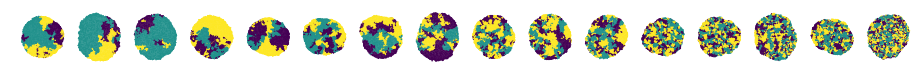

In [4]:
# plot single replicate for each batch
fig = sweep.plot_culture_grid(replicate_id=5, s=2)

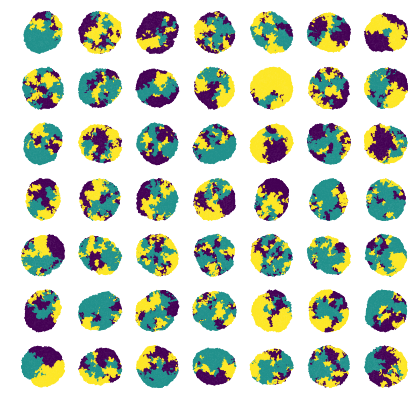

In [5]:
# plot all replicates for a single batch
fig = sweep.batches[0, 4].plot_culture_grid()

# load benchmarking results

In [5]:
df = sweep.benchmark_results

In [6]:
data = df.groupby(['row_id', 'column_id', 'scale_id'])[['simple', 'community']].mean()

Text(0.5,0,'Column ID (Recombination start)')

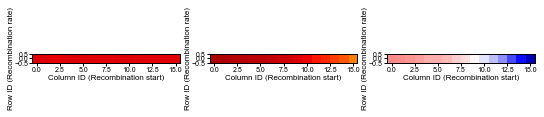

In [8]:
scale_id = 4
scale = data.xs(scale_id, level=2)
shape = [len(s) for s in scale.index.levels]
matrices = scale.simple.values.reshape(shape), scale.community.values.reshape(shape)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3))

for ax, matrix in zip(axes[:-1], matrices):
    ax.imshow(1-matrix, cmap=plt.cm.jet, vmin=0.5, vmax=1)
    ax.invert_yaxis()
    ax.set_ylabel('Row ID (Recombination rate)')
    ax.set_xlabel('Column ID (Recombination start)')
    

# positive means new method is doing well    
difference = matrices[0] - matrices[1] 
ax = axes[-1]
ax.imshow(difference, cmap=plt.cm.seismic, vmin=-0.1, vmax=0.1)
ax.invert_yaxis()
ax.set_ylabel('Row ID (Recombination rate)')
ax.set_xlabel('Column ID (Recombination start)')

Text(0.5,0,'Clone size')

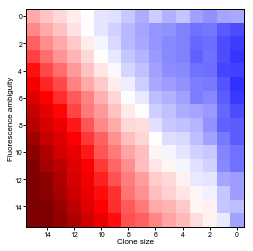

In [9]:
row_id = 0

new = data.xs(row_id, level=0).swaplevel().sort_index(level=0)
shape = [len(s) for s in new.index.levels]
matrices = new.values.reshape(*shape, 2)

# positive means new method is higher accuracy
#differential = -np.diff(matrices).reshape(*shape) 
#normalized_differential = differential / matrices.mean(axis=-1)
foldchange = np.log2(matrices[:,:,1]/matrices[:,:,0])

fig, ax = plt.subplots()
ax.imshow(foldchange, vmin=-3, vmax=3, cmap=plt.cm.seismic)
#ax.invert_yaxis()
ax.invert_xaxis()

ax.set_ylabel('Fluorescence ambiguity')
ax.set_xlabel('Clone size')

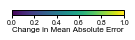

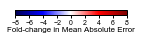

In [39]:
cbar = ColorBar(label='Change in Mean Absolute Error')

ebar = ErrorColorbar(vlim=(-8, 8), label='Fold-change in Mean Absolute Error')

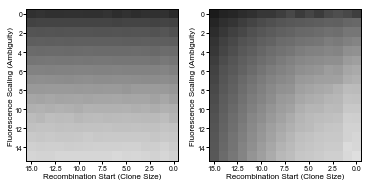

In [40]:
row_id = 0

new = data.xs(row_id, level=0).swaplevel().sort_index(level=0)
shape = [len(s) for s in new.index.levels]
matrices = new.values.reshape(*shape, 2)
simple, community = matrices[:,:,0], matrices[:,:,1]

fig, axes = plt.subplots(ncols=2, figsize=(6, 3))
for ax, matrix in zip(axes, [simple, community]):
    ax.imshow(np.log10(matrix), vmin=-3, vmax=-0.5, cmap=plt.cm.Greys)
    ax.invert_xaxis()
    ax.set_ylabel('Fluorescence Scaling (Ambiguity)')
    ax.set_xlabel('Recombination Start (Clone Size)')

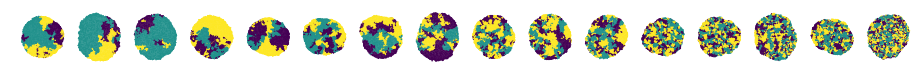

In [10]:
# plot single replicate for each batch
fig = sweep.plot_culture_grid(replicate_id=5, s=2)

In [4]:
from clones.validation.simulation import SimulationBenchmark

In [5]:
sweep_benchmark = SweepBenchmark.load(sweep_path)

In [6]:
batch_id, scale_id = 0, 10
batch_benchmark = sweep_benchmark.load_benchmark(batch_id, scale_id)

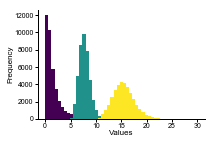

In [7]:
batch_benchmark.classifier.show(xlim=(0, 30))

In [8]:
simulation_benchmark = batch_benchmark.benchmark_simulation(0)

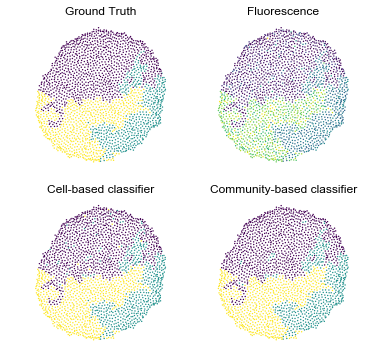

In [9]:
simulation_benchmark.show()

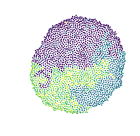

In [10]:
simulation_benchmark.plot_measurements()